In [17]:
filepath = r"c:\Users\Lindsay\Documents\alexander\Honors\data_with_coords\Cas9-B1\P1000355\ts02DLC_resnet50_single_tadpoleNov23shuffle1_1030000.h5"


# Load Data

In [18]:
import pandas as pd
data_in = pd.read_hdf(filepath)

## Drop Scorer Row

In [19]:
data=data_in.copy()
data.columns = data.columns.droplevel(level='scorer')

# Functions

In [20]:
import numpy as np
# function to adjust eyeball posistion sif ther eis a low likelihood for the position of an eye
def adjust_eyes(left_eye_column_in, right_eye_column_in, likelihood_threshold=0.998):
    # copy data
    left_eye_column= left_eye_column_in
    right_eye_column=  right_eye_column_in
    # check same shape input data
    if left_eye_column.shape!=right_eye_column.shape:
        # print("Error, shape of right and left eye data frames differs")
        return(pd.DataFrame([]))

    for i in range(left_eye_column.shape[0]):
        # If unsure of both eyes, replace with last known position or skip if i=0
        if left_eye_column.at[i,'likelihood']<likelihood_threshold and right_eye_column.at[i,'likelihood']<likelihood_threshold:
            if i==0:
                #print("Error, unsure of both eye positions on first data point, skipping correction")
                continue 
            else:
                left_eye_column.at[i,'x']= left_eye_column[i-1,'x']
                right_eye_column.at[i,'x']= right_eye_column[i-1,'x']
                left_eye_column.at[i,'y']= left_eye_column[i-1,'y']
                right_eye_column.at[i,'y']= right_eye_column[i-1,'y']
                print("unsure of both predictions of eyes, using previous")
                continue
    
        # If unsure of left eye only ( exclusive because of guard statement above)
        if left_eye_column.at[i,'likelihood']<likelihood_threshold:
            #print("left eye unsure as likelihood is " + str(left_eye_column.at[i,'likelihood']) + "\n replacing " + str(left_eye_column.at[i,'x']) + " " + str(left_eye_column.at[i,'y']) + " with " + str(right_eye_column.at[i,'x']) + " " + str(right_eye_column.at[i,'y']))
            left_eye_column.at[i,'x']= right_eye_column.at[i,'x']
            left_eye_column.at[i,'y']= right_eye_column.at[i,'y']
            

        # If unsure of Right eye only ( exclusive because of guard statement above)
        if right_eye_column.at[i,'likelihood']<likelihood_threshold:
            #print("right eye unsure as likelihood is " + str(right_eye_column.at[i,'likelihood']) + "\n replacing " + str(right_eye_column.at[i,'x']) + " " + str(right_eye_column.at[i,'y']) + " with " + str(left_eye_column.at[i,'x']) + " " + str(left_eye_column.at[i,'y']))
            right_eye_column.at[i,'x']= left_eye_column.at[i,'x']
            right_eye_column.at[i,'y']= left_eye_column.at[i,'y']
    return (left_eye_column, right_eye_column)


def get_frons(left_eye_column_in, right_eye_column_in):
    # function to calculate frons position - frons is halfway between the 2 eyes
    frons_x= (left_eye_column_in["x"]+right_eye_column_in["x"])/2
    frons_y=(left_eye_column_in["y"]+right_eye_column_in["y"])/2
    frons_index = pd.MultiIndex.from_product([["frons"], ["x", "y"]])
    frons_df = pd.DataFrame( columns=frons_index)
    frons_df[("frons", "x")] = frons_x
    frons_df[("frons", "y")] = frons_y
    return frons_df

def get_com(left_eye_column_in, right_eye_column_in, tail_base_column_in):
    # function to calculate centre of mass of the tadpole
    com_x= (left_eye_column_in["x"]+right_eye_column_in["x"]+tail_base_column_in["x"])/3
    com_y=(left_eye_column_in["y"]+right_eye_column_in["y"]+tail_base_column_in["y"])/3
    com_index = pd.MultiIndex.from_product([["com"], ["x", "y"]])
    com_df = pd.DataFrame( columns=com_index)
    com_df[("com", "x")] = com_x
    com_df[("com", "y")] = com_y
    return com_df

def extract_xy_vectors(df):
    vecs_out=[]
    for index, row in df.iterrows():
    # Extract x and y coordinates into a tuple
        coord_tuple = (row['x'], row['y'])
        # Append the tuple to list
        vecs_out.append(coord_tuple)
    return(vecs_out)

def get_yaw(frons_col_in,tail_base_col_in):
    frons_vecs = extract_xy_vectors(frons_col_in)
    tail_base_vecs = extract_xy_vectors(tail_base_col_in)

    yaws_cartesian = []
    yaws_radians = []
    # Iterate over both lists simultaneously using zip
    for frons_vec, tail_base_vec in zip(frons_vecs, tail_base_vecs):
        # Compute the difference between corresponding vectors
        diff_x = frons_vec[0] - tail_base_vec[0]
        diff_y = frons_vec[1] - tail_base_vec[1]
        # Append the difference vector to the list
        yaws_cartesian.append((diff_x, diff_y))
        yaws_radians.append(np.arctan2(diff_y, diff_x))
    # create dataframe for yaws to be compatible with other df
    yaw_index = pd.MultiIndex.from_product([["yaw"], ["yaw_cartesian", "yaw_radians"]])
    yaw_df=pd.DataFrame( columns=yaw_index)
    yaw_df[("yaw", "yaw_cartesian")] = yaws_cartesian
    yaw_df[("yaw", "yaw_radians")] = yaws_radians
    return(yaw_df)

def get_yaw_diff(yaw_rads_in):
    yaw_rads_diff=yaw_rads_in.diff()
    yaw_rads_diff=yaw_rads_diff.drop(0)
    last_yaw=yaw_rads_diff.iloc[-1]
    last_yaw_series = pd.Series(last_yaw, index=[len(yaw_rads_diff)])
    yaw_rads_diff = pd.concat([yaw_rads_diff, last_yaw_series])
    return yaw_rads_diff.reset_index(drop=True)

def get_yaw_speed(yaw_diff_in, fps=50):
    yaw_speeds=yaw_diff_in*fps
    return yaw_speeds

def get_com_diff (com_in):
    difference_vectors = []
    # Iterate through the dataframe to calculate the difference vectors
    for i in range(1, len(com_in)):
        x_diff = com_in.loc[i, 'x'] - com_in.loc[i-1, 'x']
        y_diff = com_in.loc[i, 'y'] - com_in.loc[i-1, 'y']
        difference_vectors.append((x_diff, y_diff))
    difference_vectors.append((x_diff, y_diff)) # append last value twice
    return difference_vectors

def get_2d_rotation_matrix(yaw):
    # Define the 2D rotation matrix
    rotation_matrix = np.array([[np.cos(yaw), -np.sin(yaw)],
                                [np.sin(yaw), np.cos(yaw)]])
    return(rotation_matrix)

def get_thrust_and_slip(yaw_col_in,com_diff_col_in):
    thrusts = []
    slips = []
    rotated_com_diffs = []
    # Iterate over both lists simultaneously using zip
    for yaw, speed in zip(yaw_col_in, com_diff_col_in):
        # Compute the difference between corresponding vectors
        rot_matrix=get_2d_rotation_matrix(-yaw)
        speed= np.array(speed) # make tuple into np array
        rotated_speed = np.dot(rot_matrix, speed)
        thrusts.append(rotated_speed[0]) # add the x component of rotated speed to the thrust set
        slips.append(rotated_speed[1]) # add y component to slips list
        rotated_com_diffs.append((rotated_speed[0],rotated_speed[1]))
    return thrusts, slips, rotated_com_diffs

## Adjust Eyes

In [21]:
data['left_eye'], data['right_eye'] = adjust_eyes(data['left_eye'], data['right_eye'])


## Create Frons

In [22]:
#get_frons(data['left_eye'], data['right_eye'])
frons_df = get_frons(data['left_eye'], data['right_eye'])
data=pd.concat([data, frons_df], axis=1)


# Create Yaw Vector

In [23]:
yaw_df = get_yaw(data['frons'], data['tail_base'])
data=pd.concat([data, yaw_df], axis=1)

## Get Yaw Difference between time points

In [24]:
yaw_diff = get_yaw_diff(data['yaw']['yaw_radians'])
data[("yaw","yaw_diff")] = yaw_diff


## Get YAw Speed

# Calculate yaw speed in same way as yaw was calculated and added

In [25]:
yaw_speed = get_yaw_speed(data['yaw']['yaw_diff'])
data[("yaw","yaw_speed")] = yaw_speed

# Create Centre of Mass

In [26]:
com_df = get_com(data['left_eye'], data['right_eye'], data['tail_base'])
data=pd.concat([data, com_df], axis=1)

# Get Com Diff

In [27]:
com_diff = get_com_diff(data["com"])
data[('com',"com_diff")] = com_diff

# Rotate Com diff to thrust and slip

In [34]:
data[("com","thrust_diff")], data[("com","slip_diff")], data[("com","rotated_com_diff")] = get_thrust_and_slip(data[("yaw", "yaw_radians")],data[("com", "com_diff")])

In [55]:
datacopy = data.copy()

In [29]:
# scale factor is number of mm per pixel ( calculate by real world dist/ n pixels)
def scale_to_mm_per_s(pixels_per_frame ,scale_factor = 0.04,  frame_rate =50):
    mm_per_frame = pixels_per_frame*scale_factor
    mm_per_sec = mm_per_frame * frame_rate
    return mm_per_sec


In [38]:
datacopy[("yaw","yaw_ms")]= scale_to_mm_per_s(data[("yaw","yaw_diff")])
datacopy[("com","thrust_ms")]= scale_to_mm_per_s(data[("com","thrust_diff")])
datacopy[("com","slip_ms")]= scale_to_mm_per_s(data[("com","slip_diff")])


# Convert from pixels/frame into m/s

datacopy

In [57]:
datacopy
# check that the thrust and slip columns are correct with these formulae

left_eye                         right_eye                         \
                x           y likelihood          x           y likelihood   
0       26.586409  120.901245   1.000000  24.731754   94.941406   0.999999   
1       26.232958  119.960770   0.999999  26.249096   95.356377   0.999999   
2       25.868507  119.002640   0.999999  27.131954   94.241699   0.999999   
3       26.860193  119.411880   0.999998  27.136055   96.196785   0.999996   
4       28.063148  119.763237   0.999999  27.094500   94.289665   0.999996   
...           ...         ...        ...        ...         ...        ...   
63211  110.866936  186.031082   0.999999  86.779572  182.933105   1.000000   
63212  111.027298  185.713394   0.999999  87.411163  183.017502   1.000000   
63213  110.808784  185.662735   0.999999  87.400635  182.653107   1.000000   
63214  110.693504  185.834976   0.999999  88.003799  182.964951   1.000000   
63215  110.973167  185.488007   0.999999  87.412064  182.400787   1.000000   

        tail_base                             tail_1  ...       yaw  \
                x           y likelihood           x  ... yaw_speed   
0       48.358440  108.659294   0.999999   65.684738  ...  2.848774   
1       49.980148  109.788307   0.999999   67.748810  ... -1.188243   
2       48.118248  108.044731   1.000000   62.765438  ... -2.469397   
3       48.773827  108.159782   0.999996   63.976784  ...  0.582679   
4       48.312290  107.606628   0.999984   66.097397  ...  4.982500   
...           ...         ...        ...         ...  ...       ...   
63211  105.419098  156.492477   1.000000  107.952431  ... -0.715387   
63212  105.388329  156.400452   1.000000  107.836006  ...  0.073299   
63213  105.324112  156.160065   1.000000  107.817802  ... -0.656537   
63214  105.224113  156.206650   1.000000  108.001274  ...  0.709818   
63215  105.379875  156.230774   1.000000  107.174484  ...  0.709818   

              com                                                            \
                x           y                                      com_diff   
0       33.225534  108.167315     (0.9285329182942732, 0.20116933186848485)   
1       34.154067  108.368484   (-0.44783083597819484, -1.2721277872721402)   
2       33.706237  107.096357      (0.5504550933837891, 0.8264592488606866)   
3       34.256692  107.922816     (0.23328781127929688, -0.702972412109375)   
4       34.489979  107.219844    (-0.31587155659993016, 0.9573771158854072)   
...           ...         ...                                           ...   
63211  101.021868  175.152222    (0.2537282307942661, -0.10843912760415719)   
63212  101.275597  175.043783    (-0.0977528889973911, -0.2184804280599053)   
63213  101.177844  174.825302     (0.12929534912109375, 0.1768900553385322)   
63214  101.307139  175.002192  (-0.052103678385421404, -0.2956695556640625)   
63215  101.255035  174.706523  (-0.052103678385421404, -0.2956695556640625)   

                                                                           \
      thrust_diff slip_diff                              rotated_com_diff   
0       -0.934579 -0.170892   (-0.9345792776773781, -0.17089193713139916)   
1        0.559711  1.227023       (0.5597107067304309, 1.227023019170448)   
2       -0.603534 -0.788531    (-0.6035344778733189, -0.7885314412740347)   
3       -0.221783  0.706686    (-0.22178349001989567, 0.7066862802071034)   
4        0.288968 -0.965838    (0.28896849557642446, -0.9658379733962738)   
...           ...       ...                                           ...   
63211   -0.163746 -0.222091  (-0.16374583426993433, -0.22209088512764827)   
63212   -0.192293  0.142523   (-0.19229272115048923, 0.14252310039118543)   
63213    0.144643 -0.164578    (0.1446428118466665, -0.16457775051052412)   
63214   -0.278821  0.111329    (-0.27882092080439913, 0.1113291227382242)   
63215   -0.277212  0.115276     (-0.2772124101904562, 0.1152760126143936)   

            yaw       com            
  

In [56]:
import pandas as pd

# Assuming datacopy is your DataFrame with MultiIndex columns
# Assuming scale_to_mm_per_s is your function to scale values

# Scale the values
scaled_yaw_ms = scale_to_mm_per_s(data[("yaw", "yaw_diff")])
scaled_thrust_ms = scale_to_mm_per_s(data[("com", "thrust_diff")])
scaled_slip_ms = scale_to_mm_per_s(data[("com", "slip_diff")])

# Assign the scaled values to the correct locations under the MultiIndex
datacopy.loc[:, ("yaw", "yaw_ms")] = scaled_yaw_ms
datacopy.loc[:, ("com", "thrust_ms")] = scaled_thrust_ms
datacopy.loc[:, ("com", "slip_ms")] = scaled_slip_ms


# Plot Tadpole Position
- npte created when juast yaw was added and com... no thrust and slip

com Y: 126.86225891113281 X: 33.88427289326986
frons Y: 131.63774871826172 X: 27.994816780090332
left_eye Y: 143.81747436523438 X: 33.145973205566406
right_eye Y: 119.45802307128906 X: 22.843660354614258
tail_1 Y: 108.58649444580078 X: 63.504024505615234
tail_2 Y: 99.74607849121094 X: 78.06440734863281
tail_3 Y: 85.8461685180664 X: 84.40963745117188
tail_base Y: 117.311279296875 X: 45.663185119628906
Yaw:  Y: 14.326469421386719 X: -17.668368339538574
tail_end Y: 67.38407897949219 X: 83.1142807006836


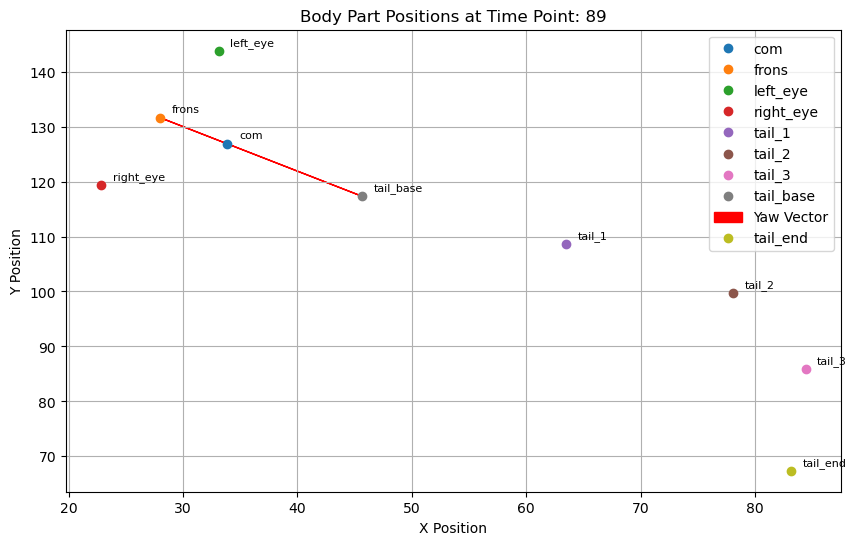

In [218]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is your DataFrame containing columns 'x', 'y', and 'yaw' with 'yaw_vector' as a sub-column
# Example DataFrame creation (replace this with your actual DataFrame)


idx_to_visualise = 89
# Get body part names from the top level of MultiIndex
bodyparts = data.columns.levels[0]

# Create the plot
plt.figure(figsize=(10, 6))  # Set plot size

# Loop through each body part
for bodypart in bodyparts:
    if bodypart == 'yaw':
        continue
    # Select data for this body part (all rows)
    bodypart_data = data.loc[idx_to_visualise, bodypart]  # Select specific level and column

    # Extract x and y data
    x_position = bodypart_data['x']
    y_position = bodypart_data['y']
    print(str(bodypart) + " Y: " + str(y_position) + " X: " + str(x_position))
    # Plot the points with labels
    plt.plot(x_position, y_position, 'o', label=bodypart)  # Plot and label
    plt.text(x_position + 1, y_position + 1, bodypart, fontsize=8)  # Add text label

    # Plot the yaw vector starting from tail_base
    if bodypart == 'tail_base':  # Assuming 'tail_base' is the starting point for yaw vectors
        # Extract yaw vector data
        yaw_vector = data.loc[idx_to_visualise, ('yaw', 'yaw_cartesian')]
        
        # Unpack x and y components of yaw vector
        yaw_x, yaw_y = yaw_vector
        print("Yaw: "+ " Y: " + str(yaw_y) + " X: " + str(yaw_x))
        # Plot the yaw vector starting from tail_base point
        plt.arrow(x_position, y_position, yaw_x, yaw_y, color='r', label='Yaw Vector')

# Configure plot
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Body Part Positions at Time Point: " + str(idx_to_visualise))
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


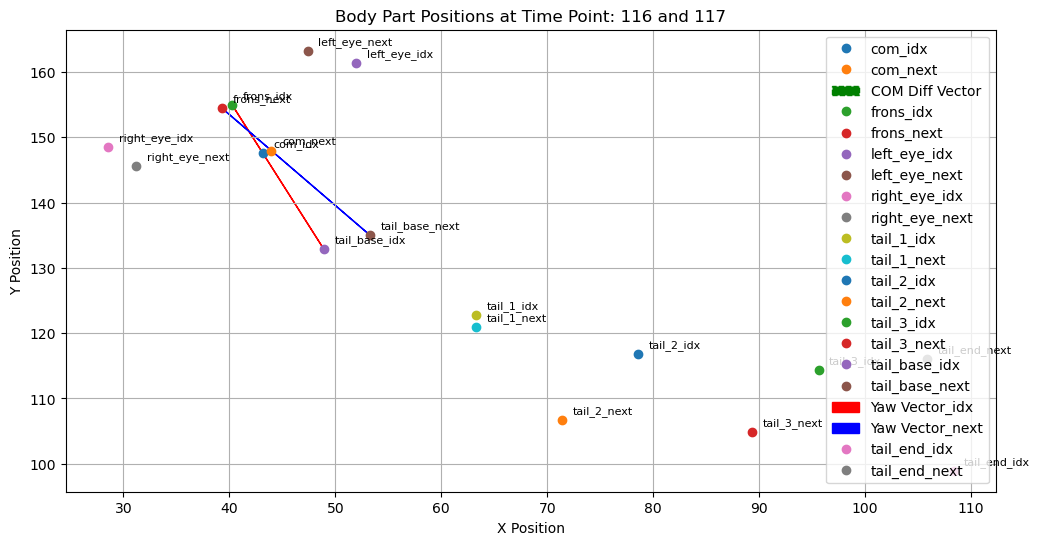

In [334]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is your DataFrame containing columns 'x', 'y', 'yaw', 'com', 'com_diff', and 'rotated_com_diff'


idx_to_visualise = 116
next_index = idx_to_visualise + 1

# Get body part names from the top level of MultiIndex
bodyparts = data.columns.levels[0]

# Create the plot
plt.figure(figsize=(12, 6))

# Loop through each body part
for bodypart in bodyparts:
    if bodypart == 'yaw':
        continue

    # Select data for the current index and the next index
    bodypart_data_idx = data.loc[idx_to_visualise, bodypart]  # Data for idx_to_visualise
    bodypart_data_next = data.loc[next_index, bodypart]     # Data for next index

    # Extract x and y data for both indices
    x_position_idx = bodypart_data_idx['x']
    y_position_idx = bodypart_data_idx['y']
    x_position_next = bodypart_data_next['x']
    y_position_next = bodypart_data_next['y']

    # Plot the points for both indices with labels
    plt.plot(x_position_idx, y_position_idx, 'o', label=bodypart + '_idx')  # Plot idx_to_visualise
    plt.plot(x_position_next, y_position_next, 'o', label=bodypart + '_next')  # Plot next index
    plt.text(x_position_idx + 1, y_position_idx + 1, bodypart+ '_idx', fontsize=8)  # Add text label
    plt.text(x_position_next + 1, y_position_next + 1, bodypart+ '_next', fontsize=8)  # Add text label


    # Plot the yaw vector starting from tail_base for idx_to_visualise
    if bodypart == 'tail_base':  # Assuming 'tail_base' is the starting point for yaw vectors
        # Extract yaw vector data for idx_to_visualise
        yaw_vector_idx = data.loc[idx_to_visualise, ('yaw', 'yaw_cartesian')]
        # Unpack x and y components of yaw vector for idx_to_visualise
        yaw_x_idx, yaw_y_idx = yaw_vector_idx
        # Plot the yaw vector starting from tail_base point for idx_to_visualise
        plt.arrow(x_position_idx, y_position_idx, yaw_x_idx, yaw_y_idx, color='r', label='Yaw Vector_idx')

    # Plot the yaw vector starting from tail_base for next index
    if bodypart == 'tail_base':  # Assuming 'tail_base' is the starting point for yaw vectors
        # Extract yaw vector data for next index
        yaw_vector_next = data.loc[next_index, ('yaw', 'yaw_cartesian')]
        # Unpack x and y components of yaw vector for next index
        yaw_x_next, yaw_y_next = yaw_vector_next
        # Plot the yaw vector starting from tail_base point for next index
        plt.arrow(x_position_next, y_position_next, yaw_x_next, yaw_y_next, color='b', label='Yaw Vector_next')

    # Plot the center of mass difference vector
    if bodypart=='com':
        com_diff_vector = data.loc[idx_to_visualise, ('com', 'com_diff')]
        com_diff_x, com_diff_y = com_diff_vector
        plt.arrow(x_position_idx, y_position_idx, com_diff_x, com_diff_y, color='g', linestyle='--', label='COM Diff Vector')

# Configure plot
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Body Part Positions at Time Point: " + str(idx_to_visualise) + " and " + str(next_index))
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Plot with 2 subplots, 1 with vectors and 1 with tadpoles

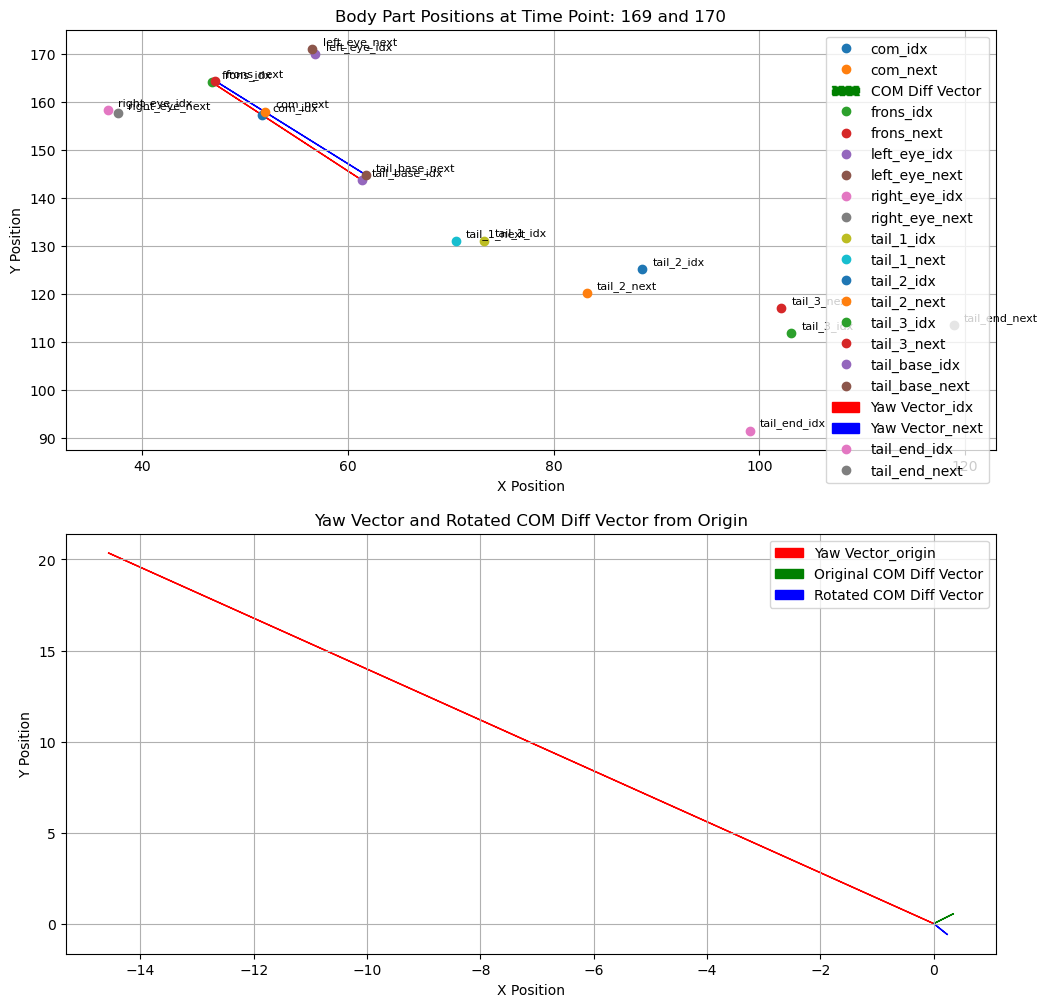

In [348]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is your DataFrame containing columns 'x', 'y', 'yaw', 'com', 'com_diff', and 'rotated_com_diff'


idx_to_visualise = 169
next_index = idx_to_visualise + 1

# Get body part names from the top level of MultiIndex
bodyparts = data.columns.levels[0]

# Create the plot
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Loop through each body part
for bodypart in bodyparts:
    if bodypart == 'yaw':
        continue

    # Select data for the current index and the next index
    bodypart_data_idx = data.loc[idx_to_visualise, bodypart]  # Data for idx_to_visualise
    bodypart_data_next = data.loc[next_index, bodypart]     # Data for next index

    # Extract x and y data for both indices
    x_position_idx = bodypart_data_idx['x']
    y_position_idx = bodypart_data_idx['y']
    x_position_next = bodypart_data_next['x']
    y_position_next = bodypart_data_next['y']

    # Plot the points for both indices with labels
    axs[0].plot(x_position_idx, y_position_idx, 'o', label=bodypart + '_idx')  # Plot idx_to_visualise
    axs[0].plot(x_position_next, y_position_next, 'o', label=bodypart + '_next')  # Plot next index
    axs[0].text(x_position_idx + 1, y_position_idx + 1, bodypart+ '_idx', fontsize=8)  # Add text label
    axs[0].text(x_position_next + 1, y_position_next + 1, bodypart+ '_next', fontsize=8)  # Add text label


    # Plot the yaw vector starting from tail_base for idx_to_visualise
    if bodypart == 'tail_base':  # Assuming 'tail_base' is the starting point for yaw vectors
        # Extract yaw vector data for idx_to_visualise
        yaw_vector_idx = data.loc[idx_to_visualise, ('yaw', 'yaw_cartesian')]
        # Unpack x and y components of yaw vector for idx_to_visualise
        yaw_x_idx, yaw_y_idx = yaw_vector_idx
        # Plot the yaw vector starting from tail_base point for idx_to_visualise
        axs[0].arrow(x_position_idx, y_position_idx, yaw_x_idx, yaw_y_idx, color='r', label='Yaw Vector_idx')

    # Plot the yaw vector starting from tail_base for next index
    if bodypart == 'tail_base':  # Assuming 'tail_base' is the starting point for yaw vectors
        # Extract yaw vector data for next index
        yaw_vector_next = data.loc[next_index, ('yaw', 'yaw_cartesian')]
        # Unpack x and y components of yaw vector for next index
        yaw_x_next, yaw_y_next = yaw_vector_next
        # Plot the yaw vector starting from tail_base point for next index
        axs[0].arrow(x_position_next, y_position_next, yaw_x_next, yaw_y_next, color='b', label='Yaw Vector_next')

    # Plot the center of mass difference vector
    if bodypart=='com':
        com_diff_vector = data.loc[idx_to_visualise, ('com', 'com_diff')]
        com_diff_x, com_diff_y = com_diff_vector
        axs[0].arrow(x_position_idx, y_position_idx, com_diff_x, com_diff_y, color='g', linestyle='--', label='COM Diff Vector')

# Configure plot
axs[0].set_xlabel("X Position")
axs[0].set_ylabel("Y Position")
axs[0].set_title("Body Part Positions at Time Point: " + str(idx_to_visualise) + " and " + str(next_index))
axs[0].legend()
axs[0].grid(True)


# Extract yaw vector data for idx_to_visualise
yaw_vector_origin = data.loc[idx_to_visualise, ('yaw', 'yaw_cartesian')]
# Unpack x and y components of yaw vector from the origin
yaw_x_origin, yaw_y_origin = yaw_vector_origin

# Extract vector data for rotated_com_diff at the same row index
com_diff_rotated = data.loc[idx_to_visualise, ('com', 'rotated_com_diff')]
com_diff_rotated_x, com_diff_rotated_y = com_diff_rotated

com_diff_original = data.loc[idx_to_visualise, ('com', 'com_diff')]
com_diff_original_x, com_diff_original_y = com_diff_original

# Plot the second subplot (subplot index 1)
axs[1].arrow(0, 0, yaw_x_origin, yaw_y_origin, color='r', label='Yaw Vector_origin')
axs[1].arrow(0, 0, com_diff_original_x, com_diff_original_y, color='g', label='Original COM Diff Vector')
axs[1].arrow(0, 0, com_diff_rotated_x, com_diff_rotated_y, color='b', label='Rotated COM Diff Vector')

# Configure the second subplot
axs[1].set_xlabel("X Position")
axs[1].set_ylabel("Y Position")
axs[1].set_title("Yaw Vector and Rotated COM Diff Vector from Origin")
axs[1].legend()
axs[1].grid(True)


# Show the plot
plt.show()


# Plot of just COm moving

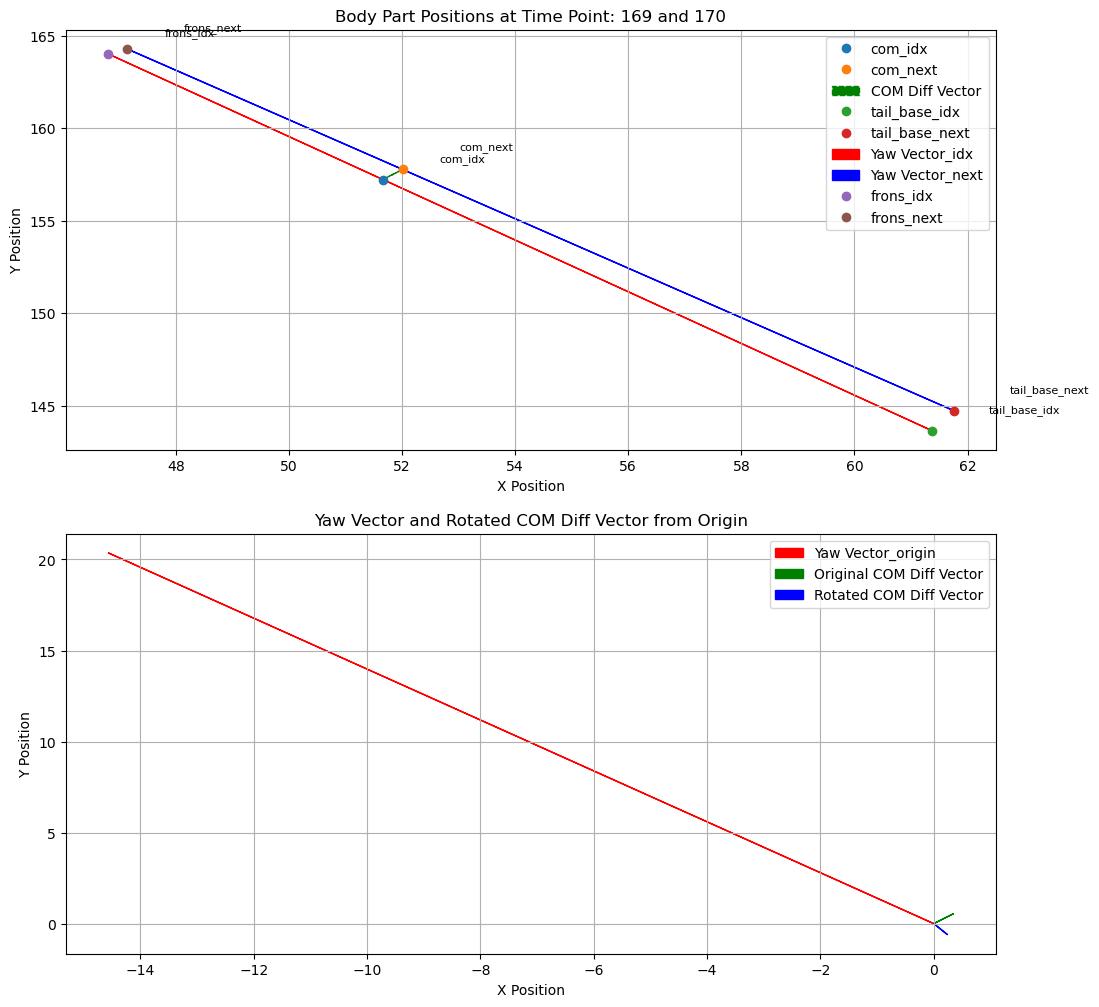

In [358]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is your DataFrame containing columns 'x', 'y', 'yaw', 'com', 'com_diff', and 'rotated_com_diff'


idx_to_visualise = 169
next_index = idx_to_visualise + 1

# Get body part names from the top level of MultiIndex
bodyparts = ["yaw", "com", "tail_base", "frons"]

# Create the plot
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Loop through each body part, only comy yaw and tail base
for bodypart in bodyparts:
    
    if bodypart == 'yaw':
        continue

    # Select data for the current index and the next index
    bodypart_data_idx = data.loc[idx_to_visualise, bodypart]  # Data for idx_to_visualise
    bodypart_data_next = data.loc[next_index, bodypart]     # Data for next index

    # Extract x and y data for both indices
    x_position_idx = bodypart_data_idx['x']
    y_position_idx = bodypart_data_idx['y']
    x_position_next = bodypart_data_next['x']
    y_position_next = bodypart_data_next['y']

    # Plot the points for both indices with labels
    axs[0].plot(x_position_idx, y_position_idx, 'o', label=bodypart + '_idx')  # Plot idx_to_visualise
    axs[0].plot(x_position_next, y_position_next, 'o', label=bodypart + '_next')  # Plot next index
    axs[0].text(x_position_idx + 1, y_position_idx + 1, bodypart+ '_idx', fontsize=8)  # Add text label
    axs[0].text(x_position_next + 1, y_position_next + 1, bodypart+ '_next', fontsize=8)  # Add text label


    # Plot the yaw vector starting from tail_base for idx_to_visualise
    if bodypart == 'tail_base':  # Assuming 'tail_base' is the starting point for yaw vectors
        # Extract yaw vector data for idx_to_visualise
        yaw_vector_idx = data.loc[idx_to_visualise, ('yaw', 'yaw_cartesian')]
        # Unpack x and y components of yaw vector for idx_to_visualise
        yaw_x_idx, yaw_y_idx = yaw_vector_idx
        # Plot the yaw vector starting from tail_base point for idx_to_visualise
        axs[0].arrow(x_position_idx, y_position_idx, yaw_x_idx, yaw_y_idx, color='r', label='Yaw Vector_idx')

    # Plot the yaw vector starting from tail_base for next index
    if bodypart == 'tail_base':  # Assuming 'tail_base' is the starting point for yaw vectors
        # Extract yaw vector data for next index
        yaw_vector_next = data.loc[next_index, ('yaw', 'yaw_cartesian')]
        # Unpack x and y components of yaw vector for next index
        yaw_x_next, yaw_y_next = yaw_vector_next
        # Plot the yaw vector starting from tail_base point for next index
        axs[0].arrow(x_position_next, y_position_next, yaw_x_next, yaw_y_next, color='b', label='Yaw Vector_next')

    # Plot the center of mass difference vector
    if bodypart=='com':
        com_diff_vector = data.loc[idx_to_visualise, ('com', 'com_diff')]
        com_diff_x, com_diff_y = com_diff_vector
        axs[0].arrow(x_position_idx, y_position_idx, com_diff_x, com_diff_y, color='g', linestyle='--', label='COM Diff Vector')

# Configure plot
axs[0].set_xlabel("X Position")
axs[0].set_ylabel("Y Position")
axs[0].set_title("Body Part Positions at Time Point: " + str(idx_to_visualise) + " and " + str(next_index))
axs[0].legend()
axs[0].grid(True)


# Extract yaw vector data for idx_to_visualise
yaw_vector_origin = data.loc[idx_to_visualise, ('yaw', 'yaw_cartesian')]
# Unpack x and y components of yaw vector from the origin
yaw_x_origin, yaw_y_origin = yaw_vector_origin

# Extract vector data for rotated_com_diff at the same row index
com_diff_rotated = data.loc[idx_to_visualise, ('com', 'rotated_com_diff')]
com_diff_rotated_x, com_diff_rotated_y = com_diff_rotated

com_diff_original = data.loc[idx_to_visualise, ('com', 'com_diff')]
com_diff_original_x, com_diff_original_y = com_diff_original

# Plot the second subplot (subplot index 1)
axs[1].arrow(0, 0, yaw_x_origin, yaw_y_origin, color='r', label='Yaw Vector_origin')
axs[1].arrow(0, 0, com_diff_original_x, com_diff_original_y, color='g', label='Original COM Diff Vector')
axs[1].arrow(0, 0, com_diff_rotated_x, com_diff_rotated_y, color='b', label='Rotated COM Diff Vector')

# Configure the second subplot
axs[1].set_xlabel("X Position")
axs[1].set_ylabel("Y Position")
axs[1].set_title("Yaw Vector and Rotated COM Diff Vector from Origin")
axs[1].legend()
axs[1].grid(True)

# Angle calcualtion 





# Show the plot
plt.show()


# Calculate angle difference

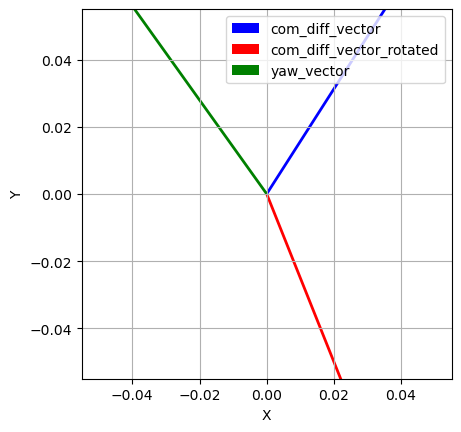

Angle between com_diff_vector and yaw_vector: 68.19220560837438 degrees
Angle between com_diff_vector_rotated and the x axis: -68.19220560837438 degrees


In [363]:
idx_to_check = 3

com_diff_vector = data.loc[idx_to_visualise, ('com', 'com_diff')]
com_diff_vector_rotated = data.loc[idx_to_visualise, ('com', 'rotated_com_diff')]
yaw_vector = data.loc[idx_to_visualise, ('yaw', 'yaw_cartesian')]


# Calculate the angle between com_diff_vector and yaw_vector
angle_com_yaw = np.arccos(np.dot(yaw_vector, com_diff_vector) / (np.linalg.norm(yaw_vector) * np.linalg.norm(com_diff_vector)))
angle_com_yaw_degrees = np.degrees(angle_com_yaw)

# Calculate the angle between com_diff_vector_rotated and the x axis
angle_com_rotated_x = np.arctan2(com_diff_vector_rotated[1],com_diff_vector_rotated[0])
angle_com_rotated_x_degrees = np.degrees(angle_com_rotated_x)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the com_diff_vector
ax.quiver(0, 0, com_diff_vector[0], com_diff_vector[1], angles='xy', scale_units='xy', scale=1, color='blue', label='com_diff_vector')

# Plot the com_diff_vector_rotated
ax.quiver(0, 0, com_diff_vector_rotated[0], com_diff_vector_rotated[1], angles='xy', scale_units='xy', scale=1, color='red', label='com_diff_vector_rotated')

# Plot the yaw_vector
ax.quiver(0, 0, yaw_vector[0], yaw_vector[1], angles='xy', scale_units='xy', scale=1, color='green', label='yaw_vector')

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.show()


# Print out the angles with messages
print("Angle between com_diff_vector and yaw_vector:", angle_com_yaw_degrees, "degrees")
print("Angle between com_diff_vector_rotated and the x axis:", angle_com_rotated_x_degrees, "degrees")

In [342]:
data

left_eye                         right_eye                         \
                x           y likelihood          x           y likelihood   
0       26.586409  120.901245   1.000000  24.731754   94.941406   0.999999   
1       26.232958  119.960770   0.999999  26.249096   95.356377   0.999999   
2       25.868507  119.002640   0.999999  27.131954   94.241699   0.999999   
3       26.860193  119.411880   0.999998  27.136055   96.196785   0.999996   
4       28.063148  119.763237   0.999999  27.094500   94.289665   0.999996   
...           ...         ...        ...        ...         ...        ...   
63211  110.866936  186.031082   0.999999  86.779572  182.933105   1.000000   
63212  111.027298  185.713394   0.999999  87.411163  183.017502   1.000000   
63213  110.808784  185.662735   0.999999  87.400635  182.653107   1.000000   
63214  110.693504  185.834976   0.999999  88.003799  182.964951   1.000000   
63215  110.973167  185.488007   0.999999  87.412064  182.400787   1.000000   

        tail_base                             tail_1  ...  \
                x           y likelihood           x  ...   
0       48.358440  108.659294   0.999999   65.684738  ...   
1       49.980148  109.788307   0.999999   67.748810  ...   
2       48.118248  108.044731   1.000000   62.765438  ...   
3       48.773827  108.159782   0.999996   63.976784  ...   
4       48.312290  107.606628   0.999984   66.097397  ...   
...           ...         ...        ...         ...  ...   
63211  105.419098  156.492477   1.000000  107.952431  ...   
63212  105.388329  156.400452   1.000000  107.836006  ...   
63213  105.324112  156.160065   1.000000  107.817802  ...   
63214  105.224113  156.206650   1.000000  108.001274  ...   
63215  105.379875  156.230774   1.000000  107.174484  ...   

                                              yaw                        \
                                    yaw_cartesian yaw_radians  yaw_diff   
0       (-22.69935894012451, -0.7379684448242188)   -3.109094  0.056975   
1      (-23.739121437072754, -2.1297340393066406)   -3.052118 -0.023765   
2      (-21.618017196655273, -1.4225616455078125)   -3.075883 -0.049388   
3      (-21.775702476501465, -0.3554496765136719)   -3.125271  0.011654   
4      (-20.733466148376465, -0.5801773071289062)   -3.113617  0.099650   
...                                           ...         ...       ...   
63211     (-6.595844268798828, 27.98961639404297)    1.802227 -0.014308   
63212    (-6.169097900390625, 27.964996337890625)    1.787920  0.001466   
63213     (-6.219402313232422, 27.99785614013672)    1.789386 -0.013131   
63214    (-5.875461578369141, 28.193313598632812)    1.776255  0.014196   
63215       (-6.187259674072266, 27.713623046875)    1.790451  0.014196   

                        com              \
      yaw_speed           x           y   
0      2.848774   33.225534  108.167315   
1     -1.188243   34.154067  108.368484   
2     -2.469397   33.706237  107.096357   
3      0.582679   34.256692  107.922816   
4      4.982500   34.489979  107.219844   
...         ...         ...         ...   
63211 -0.715387  101.021868  175.152222   
63212  0.073299  101.275597  175.043783   
63213 -0.656537  101.177844  174.825302   
63214  0.709818  101.307139  175.002192   
63215  0.709818  101.255035  174.706523   

                                                                         \
                                           com_diff    thrust      slip   
0         (0.9285329182942732, 0.20116933186848485) -0.934579 -0.170892   
1       (-0.44783083597819484, -1.2721277872721402)  0.559711  1.227023   
2          (0.5504550933837891, 0.8264592488606866) -0.603534 -0.788531   
3         (0.23328781127929688, -0.702972412109375) -0.221783  0.706686   
4        (-0.31587155659993016, 0.9573771158854072)  0.288968 -0.965838   
...                                             ...       ...       ...   
63211    (0.2537282307942661, -0.10843912760415719) -0.163746 -0

In [15]:
data

left_eye                         right_eye                         \
                x           y likelihood          x           y likelihood   
0       26.586409  120.901245   1.000000  24.731754   94.941406   0.999999   
1       26.232958  119.960770   0.999999  26.249096   95.356377   0.999999   
2       25.868507  119.002640   0.999999  27.131954   94.241699   0.999999   
3       26.860193  119.411880   0.999998  27.136055   96.196785   0.999996   
4       28.063148  119.763237   0.999999  27.094500   94.289665   0.999996   
...           ...         ...        ...        ...         ...        ...   
63211  110.866936  186.031082   0.999999  86.779572  182.933105   1.000000   
63212  111.027298  185.713394   0.999999  87.411163  183.017502   1.000000   
63213  110.808784  185.662735   0.999999  87.400635  182.653107   1.000000   
63214  110.693504  185.834976   0.999999  88.003799  182.964951   1.000000   
63215  110.973167  185.488007   0.999999  87.412064  182.400787   1.000000   

        tail_base                             tail_1  ...  \
                x           y likelihood           x  ...   
0       48.358440  108.659294   0.999999   65.684738  ...   
1       49.980148  109.788307   0.999999   67.748810  ...   
2       48.118248  108.044731   1.000000   62.765438  ...   
3       48.773827  108.159782   0.999996   63.976784  ...   
4       48.312290  107.606628   0.999984   66.097397  ...   
...           ...         ...        ...         ...  ...   
63211  105.419098  156.492477   1.000000  107.952431  ...   
63212  105.388329  156.400452   1.000000  107.836006  ...   
63213  105.324112  156.160065   1.000000  107.817802  ...   
63214  105.224113  156.206650   1.000000  108.001274  ...   
63215  105.379875  156.230774   1.000000  107.174484  ...   

                                              yaw                        \
                                    yaw_cartesian yaw_radians  yaw_diff   
0       (-22.69935894012451, -0.7379684448242188)   -3.109094  0.056975   
1      (-23.739121437072754, -2.1297340393066406)   -3.052118 -0.023765   
2      (-21.618017196655273, -1.4225616455078125)   -3.075883 -0.049388   
3      (-21.775702476501465, -0.3554496765136719)   -3.125271  0.011654   
4      (-20.733466148376465, -0.5801773071289062)   -3.113617  0.099650   
...                                           ...         ...       ...   
63211     (-6.595844268798828, 27.98961639404297)    1.802227 -0.014308   
63212    (-6.169097900390625, 27.964996337890625)    1.787920  0.001466   
63213     (-6.219402313232422, 27.99785614013672)    1.789386 -0.013131   
63214    (-5.875461578369141, 28.193313598632812)    1.776255  0.014196   
63215       (-6.187259674072266, 27.713623046875)    1.790451  0.014196   

                        com              \
      yaw_speed           x           y   
0      2.848774   33.225534  108.167315   
1     -1.188243   34.154067  108.368484   
2     -2.469397   33.706237  107.096357   
3      0.582679   34.256692  107.922816   
4      4.982500   34.489979  107.219844   
...         ...         ...         ...   
63211 -0.715387  101.021868  175.152222   
63212  0.073299  101.275597  175.043783   
63213 -0.656537  101.177844  174.825302   
63214  0.709818  101.307139  175.002192   
63215  0.709818  101.255035  174.706523   

                                                                         \
                                           com_diff    thrust      slip   
0         (0.9285329182942732, 0.20116933186848485) -0.934579 -0.170892   
1       (-0.44783083597819484, -1.2721277872721402)  0.559711  1.227023   
2          (0.5504550933837891, 0.8264592488606866) -0.603534 -0.788531   
3         (0.23328781127929688, -0.702972412109375) -0.221783  0.706686   
4        (-0.31587155659993016, 0.9573771158854072)  0.288968 -0.965838   
...                                             ...       ...       ...   
63211    (0.2537282307942661, -0.10843912760415719) -0.163746 -0